# Описание данных

## Первое тестирование:

Тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 

* id – id клиента в эксперименте
* group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
* events – сколько блюд суммарно было заказано за период

## Второе тестирование:

Была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый


* id – id клиента в эксперименте
* segment – сегмент (high/low)
* group – вид кнопки (control – старая версия, test – новая версия)
* events – сколько блюд суммарно было заказано за период

Проверим различия между тестовой и контрольной группами.

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

%matplotlib inline

Сначала прочитаем данные и выполним проверку на пустые значения.

In [13]:
test_1 = pd.read_csv('5_task_1.csv')
test_1

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38
...,...,...,...
29995,22932,C,38
29996,21787,C,25
29997,5054,C,34
29998,10254,C,27


In [14]:
test_2 = pd.read_csv('5_task_2.csv')
test_2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


In [15]:
test_1.isna().sum()

id        0
group     0
events    0
dtype: int64

In [16]:
test_2.isna().sum()

id         0
group      0
segment    0
events     0
dtype: int64

## 1 тестирование

Задача: проверить, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:

* A – прямоугольные 16:9
* B – квадратные
* C – прямоугольные 12:4

Для сравнения средних используем ANOVA.

Проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [17]:
# Тест Левена для проверки гомогенности дисперсий
stats.levene(
        test_1.query("group == 'A'").events,
        test_1.query("group == 'B'").events,
        test_1.query("group == 'C'").events,
)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

p-value > 0.05, не отклоняем нулевую гипотезу.

Убедимся, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность обязательно сделаем семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты.

In [18]:
# Проверяем распределение в каждой группе на нормальность, применив тест Шапиро-Уилка
for group in ['A', 'B', 'C']:   
    print(
        stats.shapiro(
            test_1
                .query("group == @group")
                .events
                .sample(1000, random_state=17)
        )
    )

(0.9973153471946716, 0.09609563648700714)
(0.9980798363685608, 0.31768906116485596)
(0.9981185793876648, 0.3359004259109497)


* Распределение events в группе A является нормальным
* Распределение events в группе B является нормальным
* Распределение events в группе С является нормальным

In [12]:
# Дисперсионный анализ
stats.f_oneway(
        test_1.query("group == 'A'").events,
        test_1.query("group == 'B'").events,
        test_1.query("group == 'C'").events,
)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

Однофакторный дисперсионный анализ показал, что p-value очень мало. Теперь используем критерий Тьюки, чтобы определить, между какими группами есть статистически значимые различия.

In [19]:
# Критерий Тьюки для решения проблемы множественных сравнений
print(pairwise_tukeyhsd(test_1.events, test_1.group))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


Различия выявлены между группами:
* A и B
* A и C
* B и C

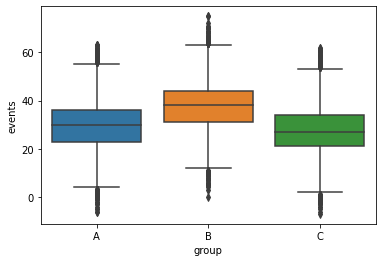

In [20]:
sns.boxplot(data=test_1, x='group', y='events')

Самое высокое среднее у группы B, поэтому будем использовать квадратные картинки.

 Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

## 2 тестирование
Задача: проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

Будем использовать многофакторный дисперсионный анализ.

Посмотрим, как распределены значение events у тестовой и контрольной групп.

Text(0.5, 0, 'events_control')

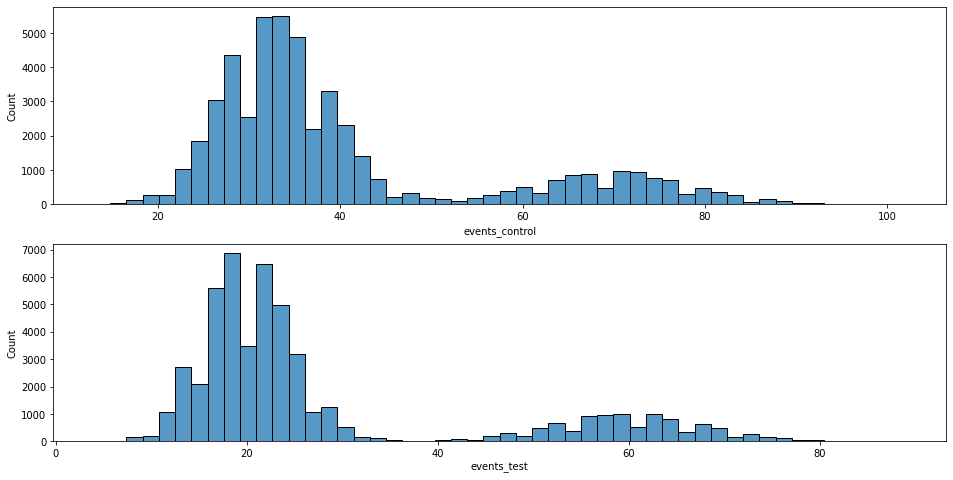

In [23]:
fig, axes = plt.subplots(2, 1, figsize=(16, 8));

# Распределение для контрольной группы с группировкой по району
sns.histplot(
    data=test_2.query("group == 'control'"),
    x   ='events',  
    bins=50,
    ax  =axes[1]
)

# Распределение для тестовой группы с группировкой по району
sns.histplot(
    data=test_2.query("group == 'test'"), 
    x   ='events',
    bins=50,
    ax  =axes[0]
)

axes[1].set_xlabel('events_test')
axes[0].set_xlabel('events_control')

In [24]:
# Описательные статистики по группе и по сегменту пользователя

(
    test_2
        .groupby(['group', 'segment'], as_index=False)
        .agg({'events':'describe'})
        .round(2)
)

group segment   events                                            
                      count   mean   std   min   25%   50%   75%    max
0  control    high  10000.0  59.97  7.81  31.0  55.0  60.0  65.0   89.0
1  control     low  40000.0  20.03  4.47   4.0  17.0  20.0  23.0   41.0
2     test    high  10000.0  69.94  8.40  40.0  64.0  70.0  76.0  102.0
3     test     low  40000.0  33.03  5.72  13.0  29.0  33.0  37.0   59.0

In [25]:
# Многофакторный дисперсионный анализ с взаимодействием факторов

formula = 'events ~ group + segment + group:segment'
model = ols(formula, test_2).fit()
aov_table = anova_lm(model, typ=2)

aov_table

,sum_sq,df,F,PR(>F)
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group:segment,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


Для последующих сравнений между группами проделаем следующую операцию: соединим колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison:

In [26]:
# Объединение названий
test_2['combinations'] = test_2['group'] + '\\' + test_2['segment']
test_2.head()

,id,group,segment,events,combinations
0,83440,test,high,78.0,test\high
1,96723,test,high,71.0,test\high
2,68719,test,high,80.0,test\high
3,50399,test,high,80.0,test\high
4,95613,test,high,78.0,test\high


In [27]:
# Критерий Тьюки
print(pairwise_tukeyhsd(test_2.events, groups=test_2.combinations).summary())

      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2   meandiff p-adj  lower    upper   reject
----------------------------------------------------------------
control\high control\low -39.9392 0.001 -40.1073 -39.7711   True
control\high   test\high   9.9677 0.001   9.7551  10.1803   True
control\high    test\low -26.9449 0.001  -27.113 -26.7768   True
 control\low   test\high  49.9069 0.001  49.7388   50.075   True
 control\low    test\low  12.9944 0.001   12.888  13.1007   True
   test\high    test\low -36.9126 0.001 -37.0807 -36.7445   True
----------------------------------------------------------------


* Для обоих сегментов показатели статистически значимо увеличились по сравнению с контрольной группой
* Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13
* Разница между control/high и test/high составила около 10

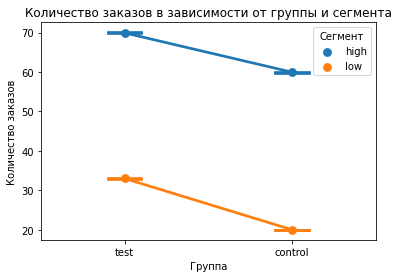

In [58]:
sns.pointplot(x='group', y='events', hue='segment', data=test_2, capsize=.2)
plt.title('Количество заказов в зависимости от группы и сегмента')
plt.xlabel('Группа')
plt.ylabel('Количество заказов')
plt.legend(title = 'Сегмент')

* Фактор group оказался значимым, фактор segment – значимым, их взаимодействие – значимо
* Судя по графику, для всех групп среднее значение events увеличилось

Решение: выкатываем новую версию кнопки.